In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
from darts import concatenate, TimeSeries
from darts.dataprocessing.transformers import MinTReconciliator  # noqa
from darts.metrics import mae, rmse  # noqa
from darts.models import (
    LinearRegressionModel,
    NaiveMovingAverage,
    ExponentialSmoothing,  # noqa: F401
    Prophet,  # noqa: F401
)  # noqa
import matplotlib.pyplot as plt
from tasks_support_system_ai.data.reader import read_data
import seaborn as sns
from tasks_support_system_ai.data.reader import DataFrames

Support for Torch based models not available. To enable them, install "darts", "u8darts[torch]" or "u8darts[all]" (with pip); or "u8darts-torch" or "u8darts-all" (with conda).


In [3]:
import logging

logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [4]:
df = read_data(DataFrames.TS_DAILY)

In [5]:
df.head()

,queueId,date,new_tickets
0,1,2017-01-01,15
1,1,2017-01-02,26
2,1,2017-01-03,25
3,1,2017-01-04,29
4,1,2017-01-05,26


In [6]:
tree = read_data(DataFrames.TS_HIERARCHY_PARSED)

Нас интересуют корневые очереди с ненулевой нагрузкой

In [7]:
top_level_tree = tree[(tree["level"] == 1) & (tree["full_load"] != 0)]
top_level_tree.sort_values("full_load", ascending=False)

,queueId,level,immediateDescendants,allDescendants,full_load
7,10,1,"[4472, 472, 4733, 1571, 100118, 2657, 2658, 27...","[10, 104, 462, 472, 1322, 1571, 2190, 2200, 24...",2463146
481,1866,1,"[4307, 4352, 4587, 4667, 4682, 762, 100081, 10...","[762, 1866, 2382, 2733, 3536, 3576, 3617, 3836...",1470013
285,742,1,"[39, 98, 118, 4322, 4412, 2458, 2610, 2921, 3093]","[9, 13, 26, 39, 83, 98, 101, 110, 116, 118, 37...",1387729
26,34,1,"[1, 111, 4522, 842, 1212, 1471, 1531, 1701, 10...","[1, 34, 42, 85, 111, 392, 842, 1212, 1471, 153...",1247019
163,4447,1,"[57, 4457, 4612, 4617, 100254, 100261, 4793, 1...","[57, 382, 1162, 1741, 1881, 1887, 1981, 2007, ...",1121534
485,1871,1,"[4202, 4262, 4723, 100264, 2150, 2170, 2321, 2...","[28, 63, 122, 632, 1062, 1201, 1401, 1871, 198...",1006818
143,4397,1,"[18, 29, 442, 100272, 100042, 2199, 2403, 3750]","[18, 29, 442, 2199, 2240, 2403, 2404, 2535, 32...",986415
90,115,1,"[25, 88, 4547, 4763, 1910, 100044, 100085, 216...","[25, 88, 115, 1910, 2163, 2166, 2219, 2259, 22...",896296
607,2002,1,"[71, 4482, 731, 2226, 2267, 2269, 2298, 2338, ...","[71, 731, 2002, 2226, 2267, 2269, 2298, 2335, ...",825237
41,4147,1,"[7, 14, 4442, 100329, 100034, 100092, 100105, ...","[7, 14, 2544, 3045, 3086, 3095, 3551, 3884, 41...",681754


## prediction (no external features)

In [8]:
from darts.utils.timeseries_generation import holidays_timeseries
from darts.models import RegressionModel

Будем предсказывать 19 верхнеуровневых очередей и на них валидировать модели

In [9]:
top_level_queues = list(
    top_level_tree[top_level_tree["full_load"] >= 10_000]["queueId"].values
)
len(top_level_queues), top_level_queues

(19,
 [10,
  34,
  40,
  4147,
  4167,
  115,
  4397,
  4447,
  742,
  1866,
  1871,
  100273,
  2002,
  100322,
  2641,
  2709,
  2922,
  3474,
  3936])

In [10]:
queue_id = 1871


def get_df_slice(queue_id: int):
    queues = tree[tree["queueId"] == queue_id]["allDescendants"].values[0]
    df_slice = df[df["queueId"].isin(queues)].groupby("date")[["new_tickets"]].sum()
    return df_slice


Analyzing Regression...

Analyzing Moving Average...

Analyzing Prophet...


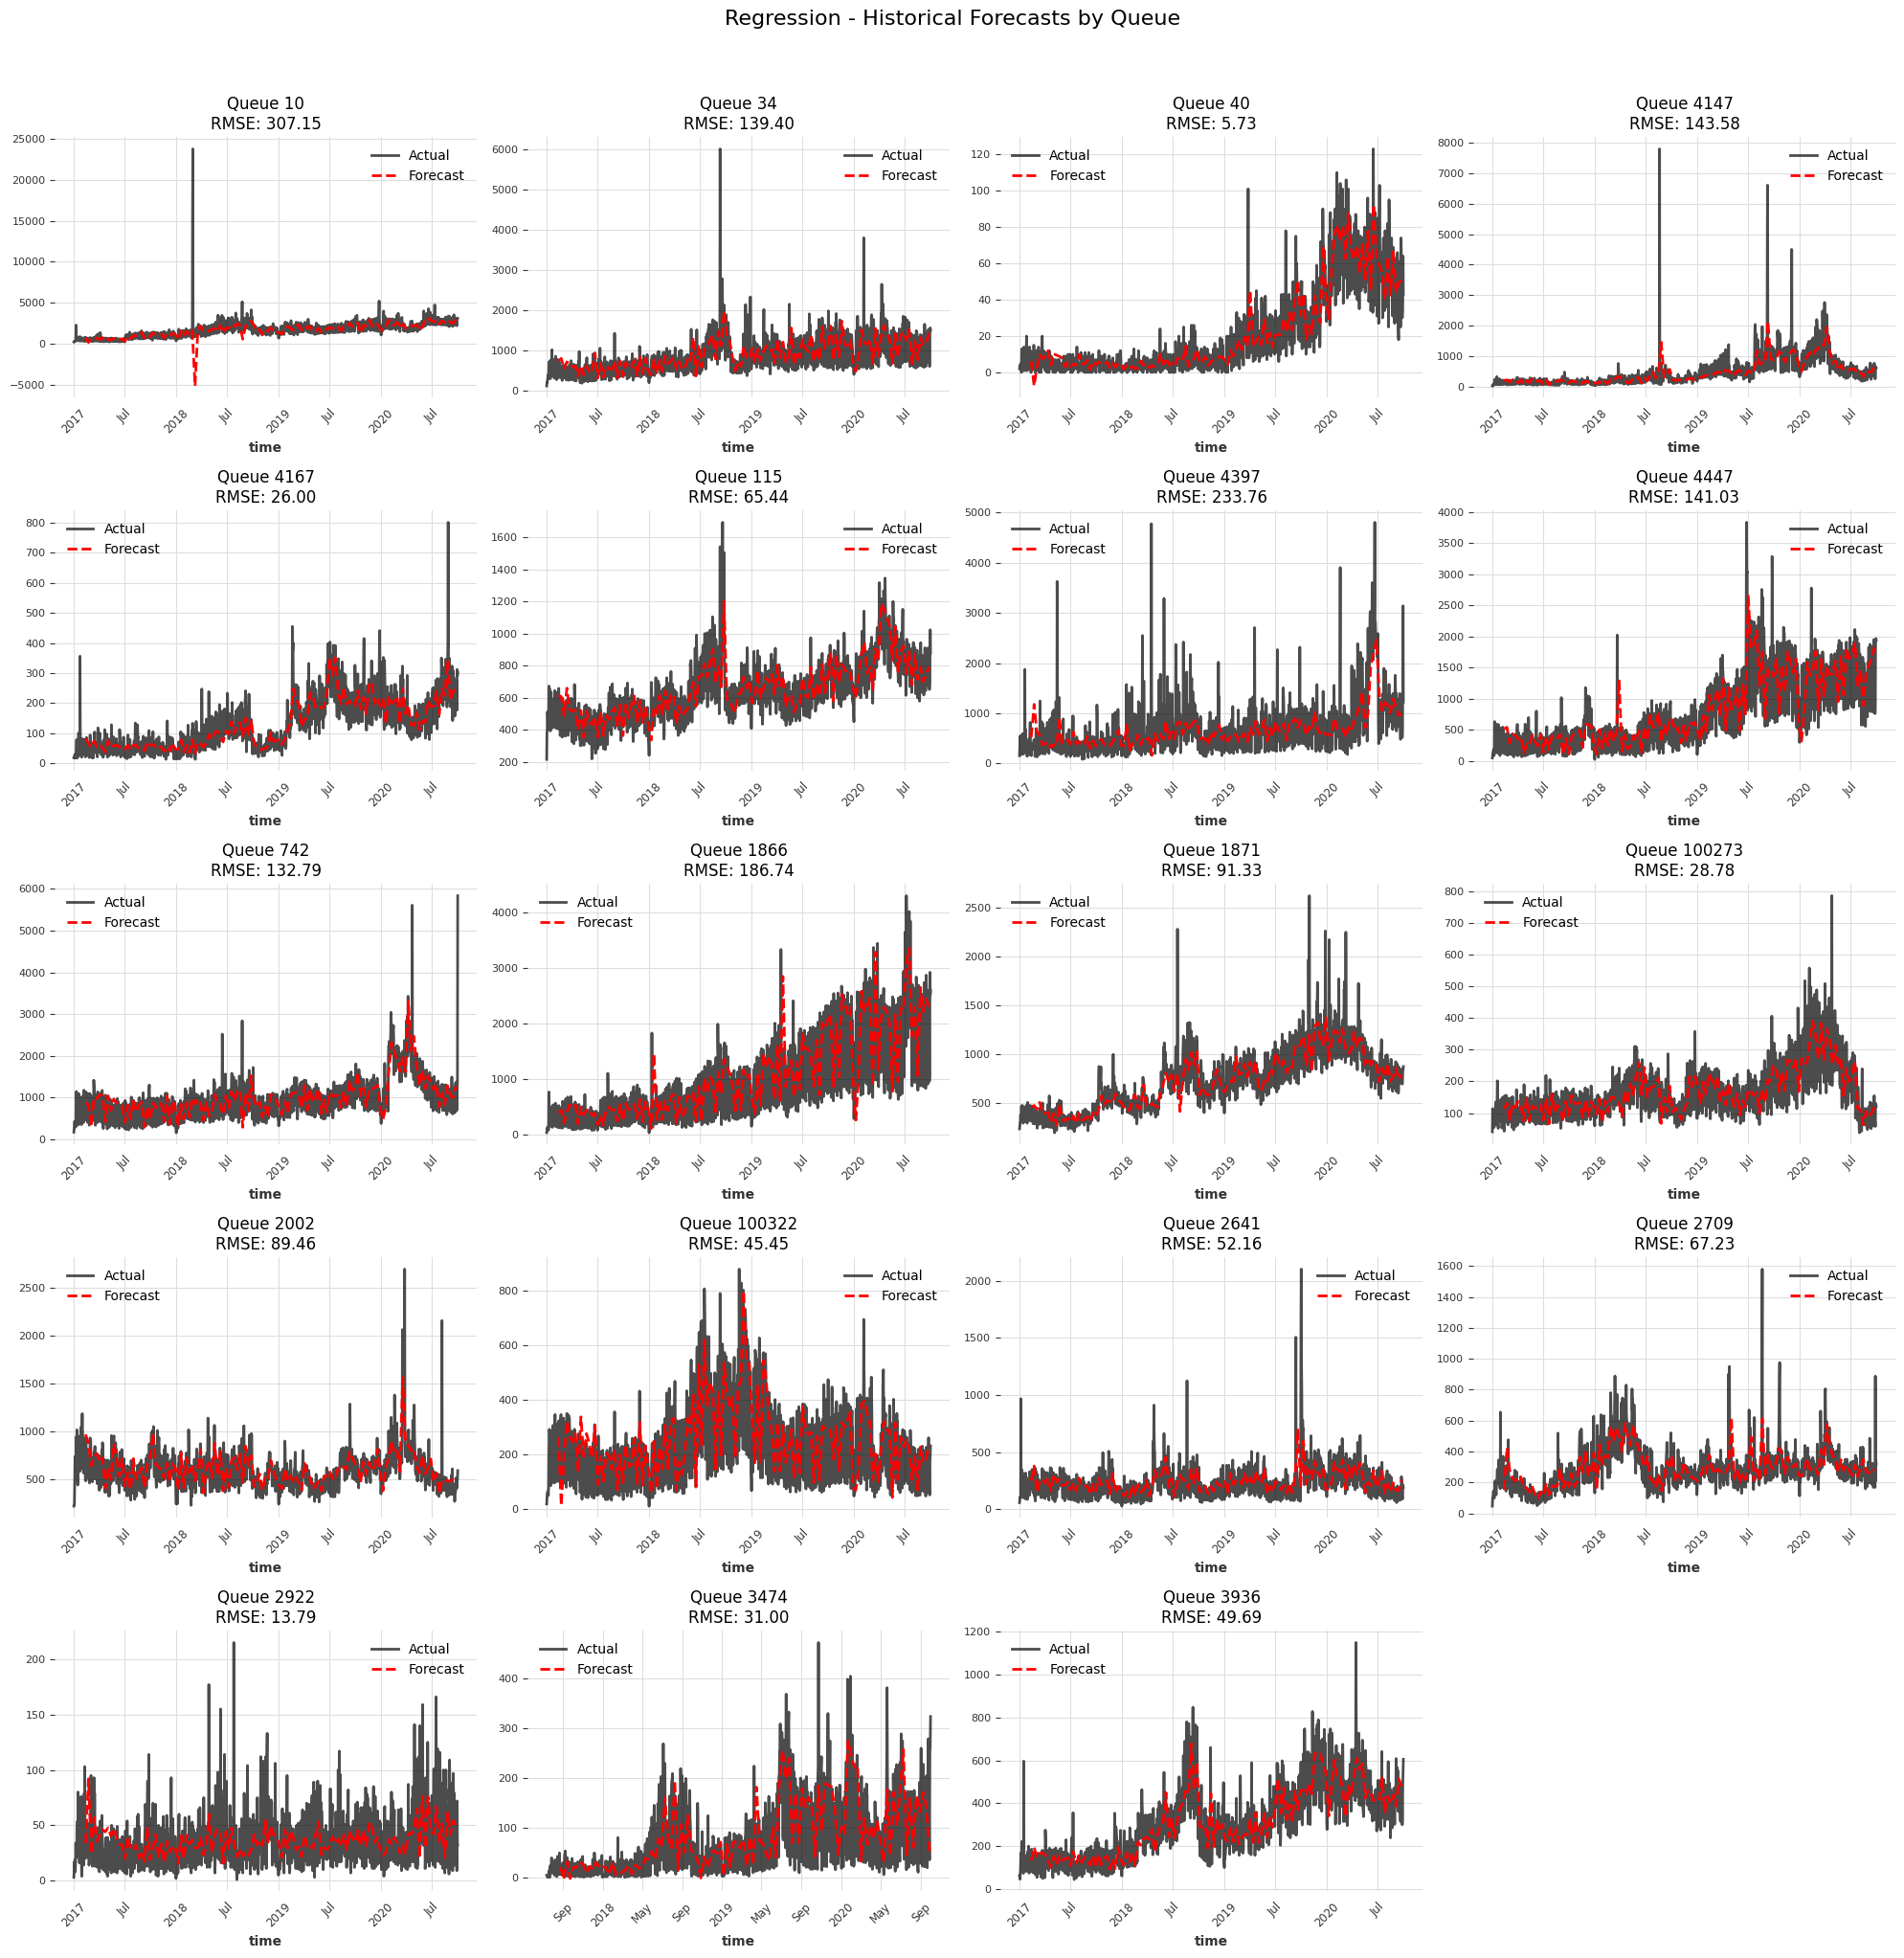

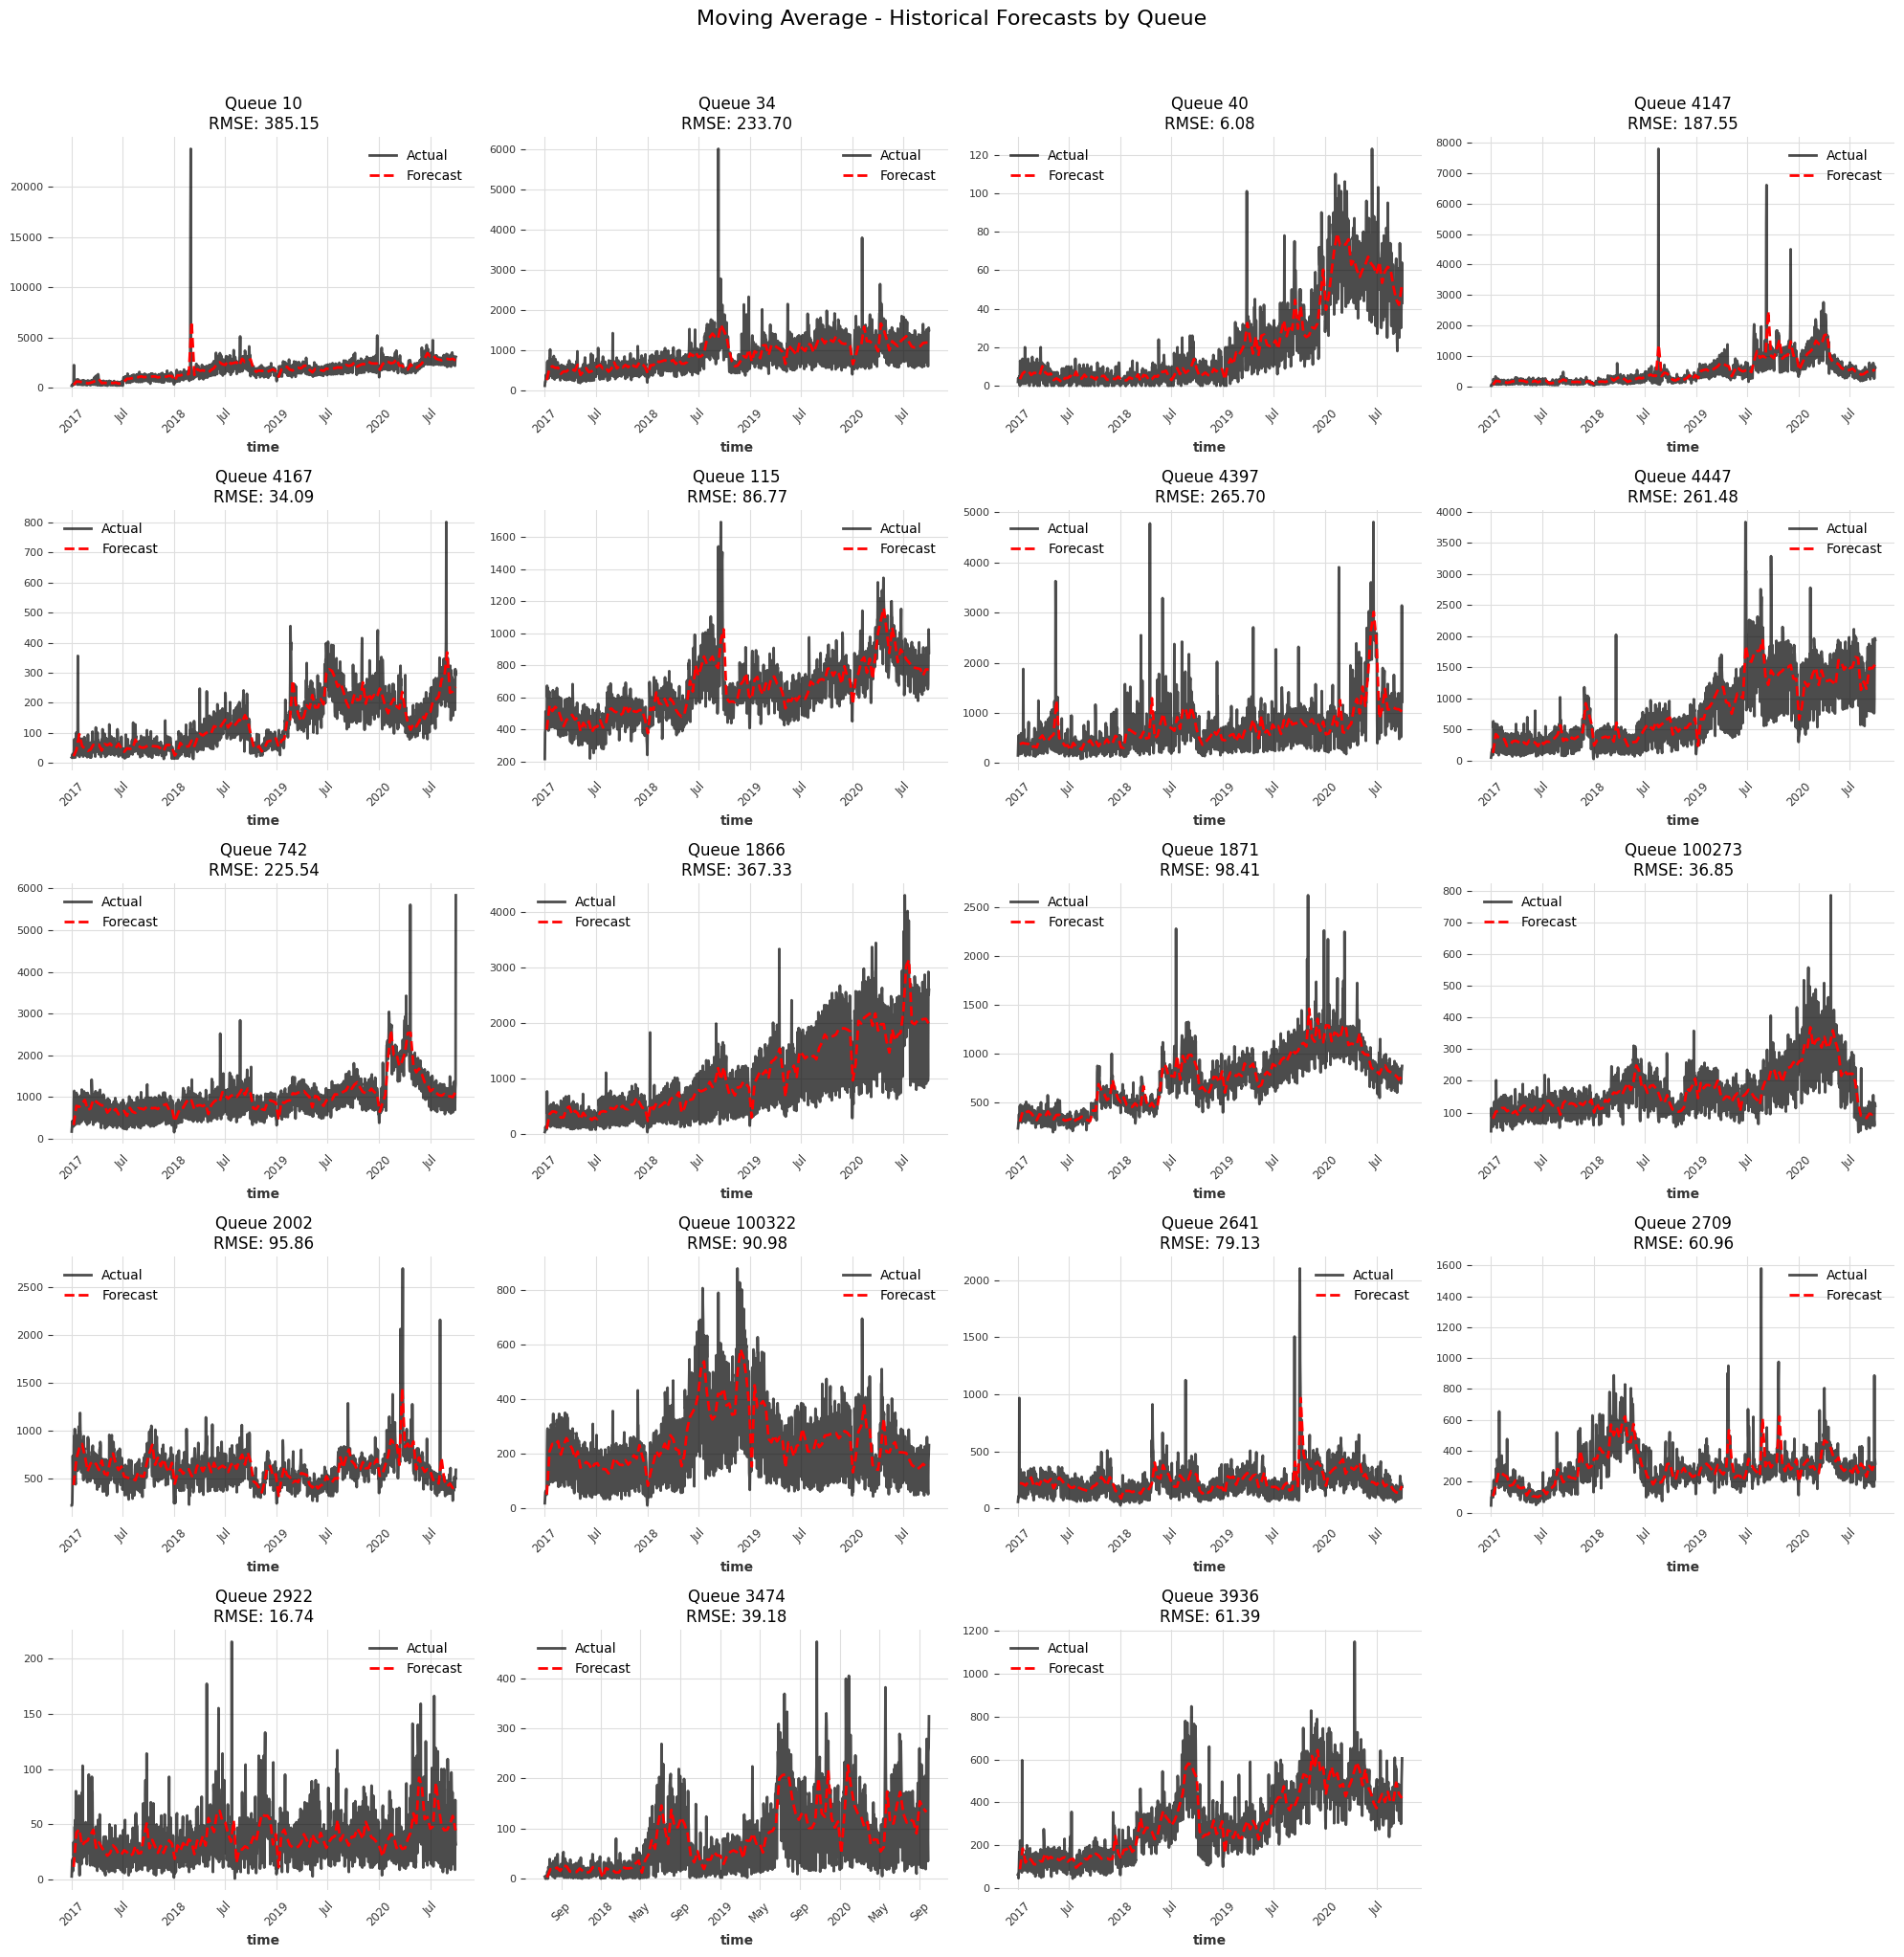

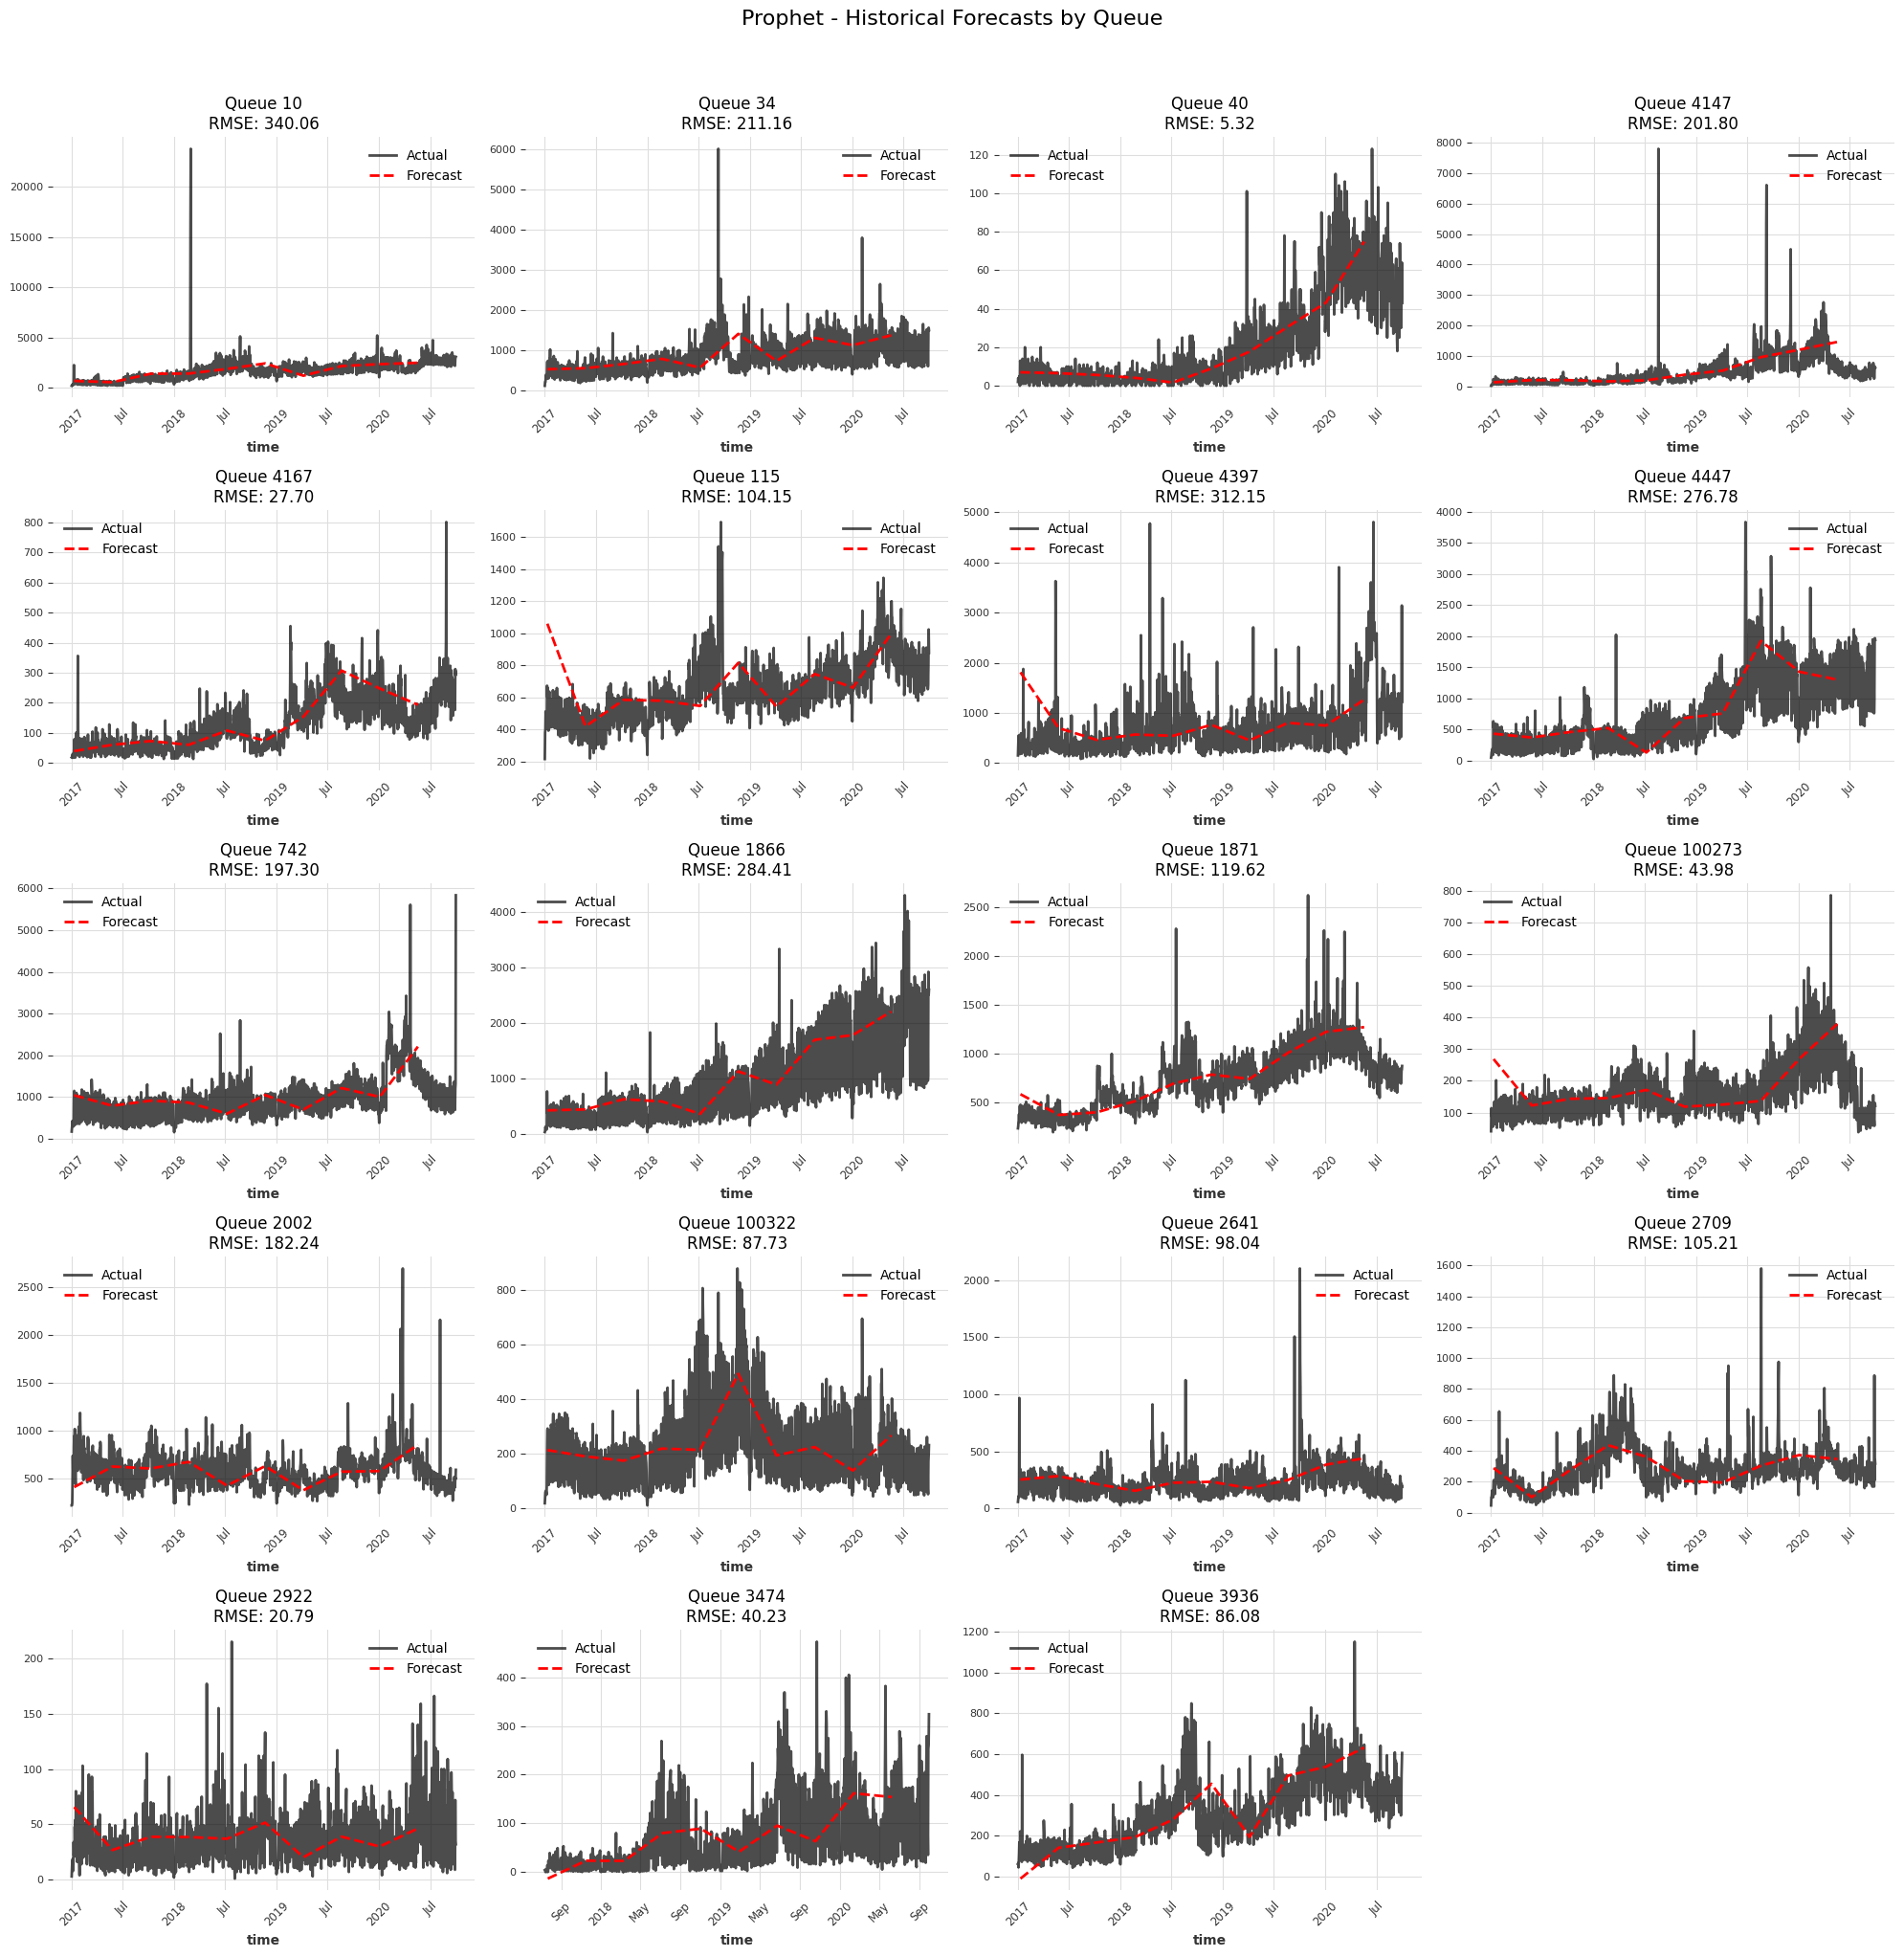

In [11]:
def analyze_queue_performances(
    top_level_queues,
    models_to_try,
    n_predict: int = 10,
    n_cols: int = 4,
):
    results = {model_name: {} for model_name in models_to_try.keys()}

    # Calculate grid dimensions
    n_queues = len(top_level_queues)
    n_rows = (n_queues + n_cols - 1) // n_cols

    for model_name, model_class in models_to_try.items():
        print(f"\nAnalyzing {model_name}...")

        fig = plt.figure(figsize=(5 * n_cols, 4 * n_rows))
        fig.suptitle(
            f"{model_name} - Historical Forecasts by Queue", y=1.02, fontsize=16
        )

        for idx, queue_id in enumerate(top_level_queues):
            df_slice = get_df_slice(queue_id)
            ts = TimeSeries.from_dataframe(
                df_slice,
                value_cols="new_tickets",
                fill_missing_dates=True,
                fillna_value=0,
                freq="D",
            )

            model = model_class
            model.fit(ts)

            # Modifications for Prophet
            if model_name == "Prophet":
                # Use larger stride and fewer forecast points
                stride = max(len(ts) // 10, 30)  # Adjust these numbers as needed
                backtest_rmse = model.backtest(
                    ts,
                    metric=rmse,
                    stride=stride,
                    show_warnings=False,
                    forecast_horizon=7,  # Reduce forecast horizon
                )
                forecasts = model.historical_forecasts(
                    ts, stride=stride, show_warnings=False, forecast_horizon=7
                )
            else:
                # Original settings for other models
                backtest_rmse = model.backtest(
                    ts, metric=rmse, stride=10, show_warnings=False
                )
                forecasts = model.historical_forecasts(
                    ts, stride=10, show_warnings=False
                )

            results[model_name][queue_id] = backtest_rmse

            # Rest of the plotting code remains the same
            ax = plt.subplot(n_rows, n_cols, idx + 1)
            ts.plot(ax=ax, label="Actual", alpha=0.7)
            forecasts.plot(ax=ax, label="Forecast", linestyle="--", color="red")
            ax.set_title(f"Queue {queue_id}\nRMSE: {backtest_rmse:.2f}")
            ax.legend()
            ax.grid(True)
            ax.tick_params(axis="x", rotation=45)
            ax.tick_params(axis="y", labelsize=8)

        plt.tight_layout()

    # Print summary statistics...
    return results


# Define models with optimized parameters for Prophet
models_to_try = {
    "Regression": RegressionModel(lags=10, output_chunk_length=31),
    "Moving Average": NaiveMovingAverage(input_chunk_length=7),
    "Prophet": Prophet(uncertainty_samples=0),
}
results = analyze_queue_performances(
    top_level_queues=top_level_queues,
    models_to_try=models_to_try,
    n_predict=10,
    n_cols=4,
)

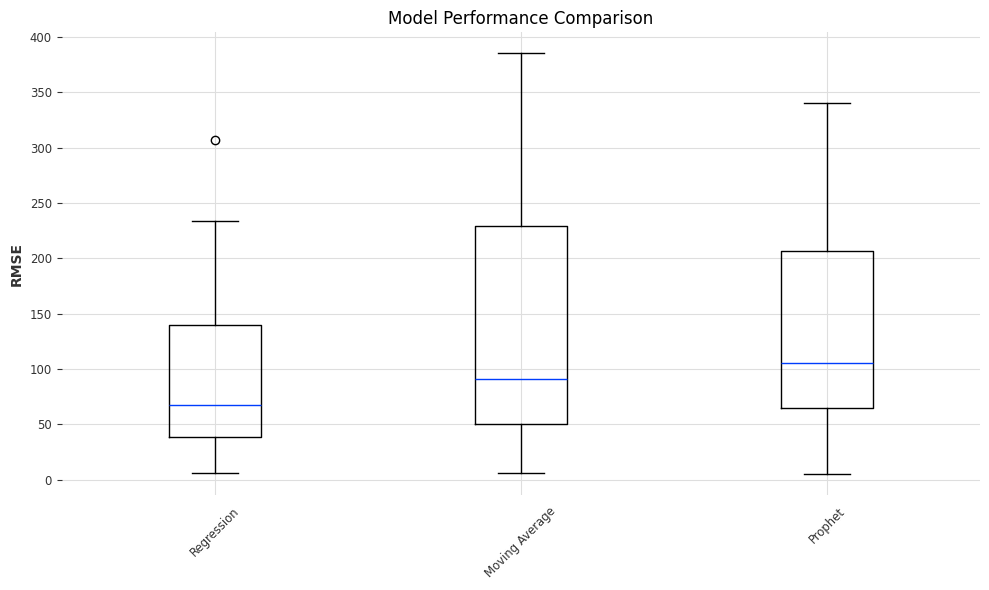

In [12]:
def plot_model_comparison(results, figsize=(10, 6)):
    """Plot boxplots comparing model performances"""
    model_data = []
    model_names = []

    for model_name, queue_results in results.items():
        model_data.append(list(queue_results.values()))
        model_names.extend([model_name] * len(queue_results))

    plt.figure(figsize=figsize)
    plt.boxplot(model_data, tick_labels=results.keys())
    plt.title("Model Performance Comparison")
    plt.ylabel("RMSE")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()


# Add after running analyze_queue_performances
plot_model_comparison(results)

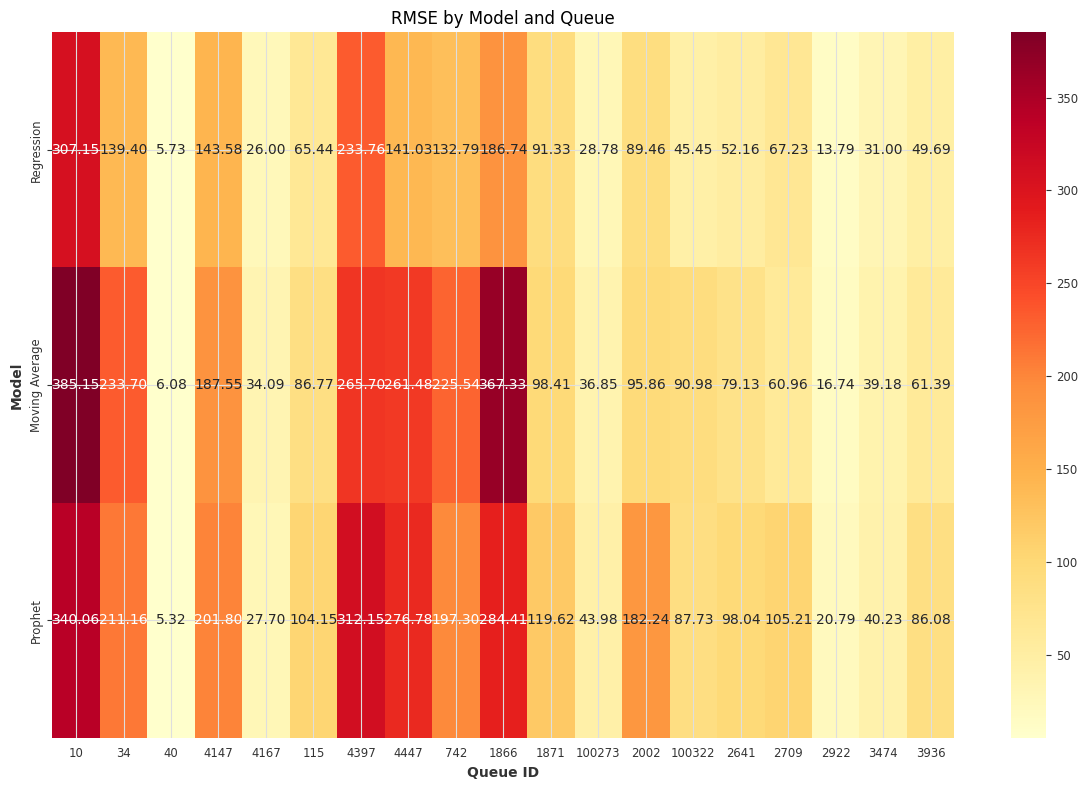

In [13]:
def plot_performance_heatmap(results, figsize=(12, 8)):
    """Plot heatmap of model performances per queue"""
    data = pd.DataFrame(results).T

    plt.figure(figsize=figsize)
    sns.heatmap(data, annot=True, fmt=".2f", cmap="YlOrRd")
    plt.title("RMSE by Model and Queue")
    plt.ylabel("Model")
    plt.xlabel("Queue ID")
    plt.tight_layout()


# Add after running


analyze_queue_performances
plot_performance_heatmap(results)

## Prediction with external features (WIP)

### past covariates
- full load


maybe:
- USD
- BTC
- weather

### future covariates
- weekends
- holidays

In [14]:
n_predict = 100
df_total = df.groupby("date")[["new_tickets"]].sum()
past_covariates = TimeSeries.from_dataframe(
    df_total,
    value_cols="new_tickets",
    fill_missing_dates=True,
    freq="D",
).with_columns_renamed("new_tickets", "all_new_tickets")
holidays = holidays_timeseries(
    time_index=past_covariates,
    country_code="RU",
    add_length=n_predict,
)


def create_weekend_timeseries(time_index, add_length=0):
    # Create full date range including prediction period
    full_range = pd.date_range(
        start=time_index[0],
        end=time_index[-1] + pd.Timedelta(days=add_length),
        freq=time_index.freq,
    )

    # Create weekend indicator (1 for weekend, 0 for weekday)
    is_weekend = [1 if x.weekday() >= 5 else 0 for x in full_range]

    # Create TimeSeries
    weekend_series = TimeSeries.from_times_and_values(
        times=full_range, values=is_weekend
    ).with_columns_renamed("0", "weekends")

    return weekend_series


weekends = create_weekend_timeseries(
    time_index=past_covariates.time_index, add_length=n_predict
)
future_covariates = holidays.concatenate(weekends, axis=1)

In [15]:
past_covariates

<TimeSeries (DataArray) (date: 1369, component: 1, sample: 1)> Size: 11kB
array([[[ 1648.]],

       [[ 2556.]],

       [[ 3055.]],

       ...,

       [[24743.]],

       [[27645.]],

       [[31039.]]])
Coordinates:
  * date       (date) datetime64[ns] 11kB 2017-01-01 2017-01-02 ... 2020-09-30
  * component  (component) object 8B 'all_new_tickets'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [16]:
future_covariates

<TimeSeries (DataArray) (time: 1469, component: 2, sample: 1)> Size: 24kB
array([[[1.],
        [1.]],

       [[1.],
        [0.]],

       [[1.],
        [0.]],

       ...,

       [[1.],
        [0.]],

       [[1.],
        [0.]],

       [[1.],
        [0.]]])
Coordinates:
  * time       (time) datetime64[ns] 12kB 2017-01-01 2017-01-02 ... 2021-01-08
  * component  (component) object 16B 'holidays' 'weekends'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [17]:
queue_id = 1871
df_slice = get_df_slice(queue_id)
ts = TimeSeries.from_dataframe(
    df_slice,
    value_cols="new_tickets",
    fill_missing_dates=True,
    fillna_value=0,
    freq="D",
)

In [18]:
ts_train = ts[:-n_predict]
ts_val = ts[n_predict:]
model = RegressionModel(
    lags=10,
    lags_past_covariates=5,
    lags_future_covariates=(5, 5),
    output_chunk_length=n_predict,
)
model.fit(
    ts_train, past_covariates=past_covariates, future_covariates=future_covariates
)

RegressionModel(lags=10, lags_past_covariates=5, lags_future_covariates=(5, 5), output_chunk_length=100, output_chunk_shift=0, add_encoders=None, model=None, multi_models=True, use_static_covariates=True)

In [19]:
model.predict(
    n_predict,
    ts_val,
    past_covariates=past_covariates,
    future_covariates=future_covariates,
)

<TimeSeries (DataArray) (date: 100, component: 1, sample: 1)> Size: 800B
array([[[1114.1003331 ]],

       [[1035.79955759]],

       [[ 883.48497274]],

       [[ 902.0403026 ]],

       [[1133.1807856 ]],

       [[1196.11939791]],

       [[1243.80628893]],

       [[1216.06620956]],

       [[1109.44842379]],

       [[ 961.87001352]],

...

       [[1626.3441978 ]],

       [[1604.50894012]],

       [[1469.66771117]],

       [[1259.81770432]],

       [[1211.01034292]],

       [[1446.27690727]],

       [[1484.82547815]],

       [[1544.91463888]],

       [[1535.68211297]],

       [[1420.37917261]]])
Coordinates:
  * date       (date) datetime64[ns] 800B 2020-10-01 2020-10-02 ... 2021-01-08
  * component  (component) object 8B 'new_tickets'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


Analyzing Regression...


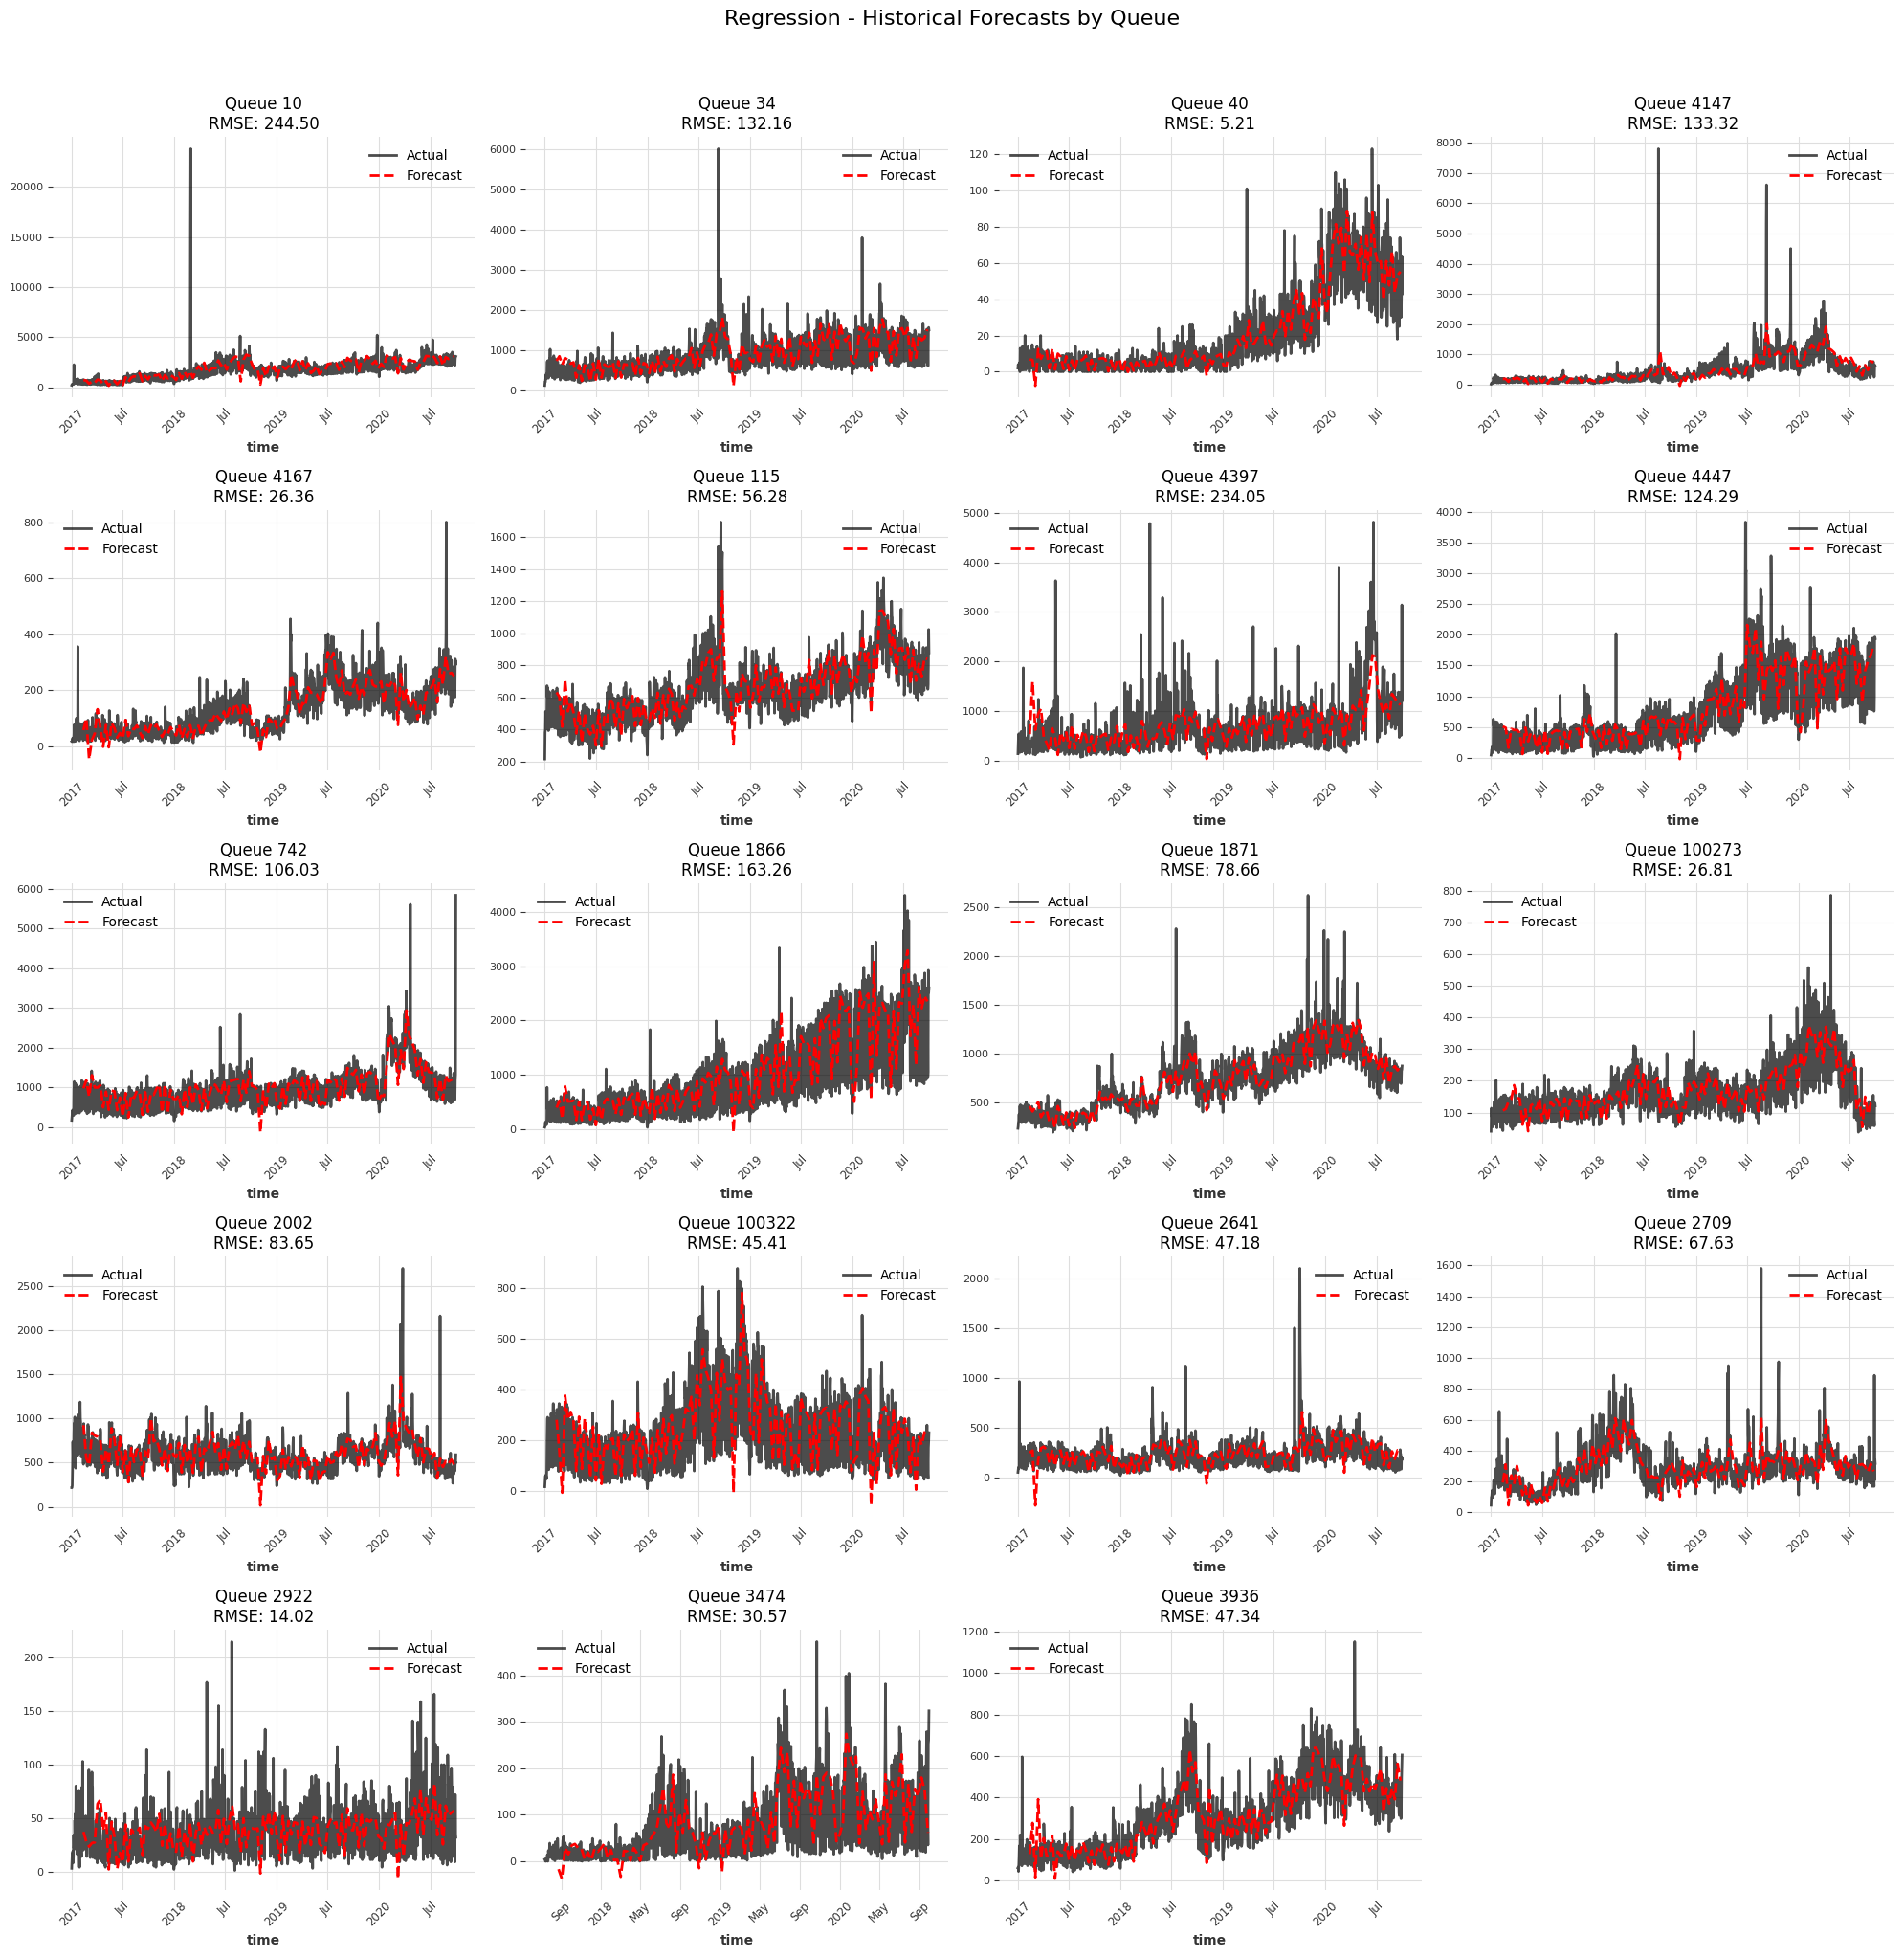

In [20]:
def analyze_queue_performances(
    top_level_queues,
    models_to_try,
    n_predict: int = 10,
    n_cols: int = 4,
):
    results = {model_name: {} for model_name in models_to_try.keys()}

    # Calculate grid dimensions
    n_queues = len(top_level_queues)
    n_rows = (n_queues + n_cols - 1) // n_cols

    for model_name, model_class in models_to_try.items():
        print(f"\nAnalyzing {model_name}...")

        fig = plt.figure(figsize=(5 * n_cols, 4 * n_rows))
        fig.suptitle(
            f"{model_name} - Historical Forecasts by Queue", y=1.02, fontsize=16
        )

        for idx, queue_id in enumerate(top_level_queues):
            df_slice = get_df_slice(queue_id)
            ts = TimeSeries.from_dataframe(
                df_slice,
                value_cols="new_tickets",
                fill_missing_dates=True,
                fillna_value=0,
                freq="D",
            )

            model = model_class
            model.fit(
                ts, past_covariates=past_covariates, future_covariates=future_covariates
            )

            # Modifications for Prophet
            if model_name == "Prophet":
                # Use larger stride and fewer forecast points
                stride = max(len(ts) // 10, 30)  # Adjust these numbers as needed
                backtest_rmse = model.backtest(
                    ts,
                    metric=rmse,
                    stride=stride,
                    show_warnings=False,
                    forecast_horizon=7,  # Reduce forecast horizon
                    past_covariates=past_covariates,
                    future_covariates=future_covariates,
                )
                forecasts = model.historical_forecasts(
                    ts,
                    stride=stride,
                    show_warnings=False,
                    forecast_horizon=7,
                    past_covariates=past_covariates,
                    future_covariates=future_covariates,
                )
            else:
                # Original settings for other models
                backtest_rmse = model.backtest(
                    ts,
                    metric=rmse,
                    stride=10,
                    show_warnings=False,
                    past_covariates=past_covariates,
                    future_covariates=future_covariates,
                )
                forecasts = model.historical_forecasts(
                    ts,
                    stride=10,
                    show_warnings=False,
                    past_covariates=past_covariates,
                    future_covariates=future_covariates,
                )

            results[model_name][queue_id] = backtest_rmse

            # Rest of the plotting code remains the same
            ax = plt.subplot(n_rows, n_cols, idx + 1)
            ts.plot(ax=ax, label="Actual", alpha=0.7)
            forecasts.plot(ax=ax, label="Forecast", linestyle="--", color="red")
            ax.set_title(f"Queue {queue_id}\nRMSE: {backtest_rmse:.2f}")
            ax.legend()
            ax.grid(True)
            ax.tick_params(axis="x", rotation=45)
            ax.tick_params(axis="y", labelsize=8)

        plt.tight_layout()

    # Print summary statistics...
    return results


# Define models with optimized parameters for Prophet
models_to_try = {
    "Regression": RegressionModel(
        lags=10,
        output_chunk_length=31,
        lags_past_covariates=5,
        lags_future_covariates=(5, 5),
    ),
    # "Moving Average": NaiveMovingAverage(
    #     input_chunk_length=7,
    #     lags=10,
    #     lags_past_covariates=5,
    #     lags_future_covariates=(5, 5),
    # ),
    # "Prophet": Prophet(
    #     uncertainty_samples=0,
    #     lags=10,
    #     lags_past_covariates=5,
    #     lags_future_covariates=(5, 5),
    # ),
}
results = analyze_queue_performances(
    top_level_queues=top_level_queues,
    models_to_try=models_to_try,
    n_predict=10,
    n_cols=4,
)

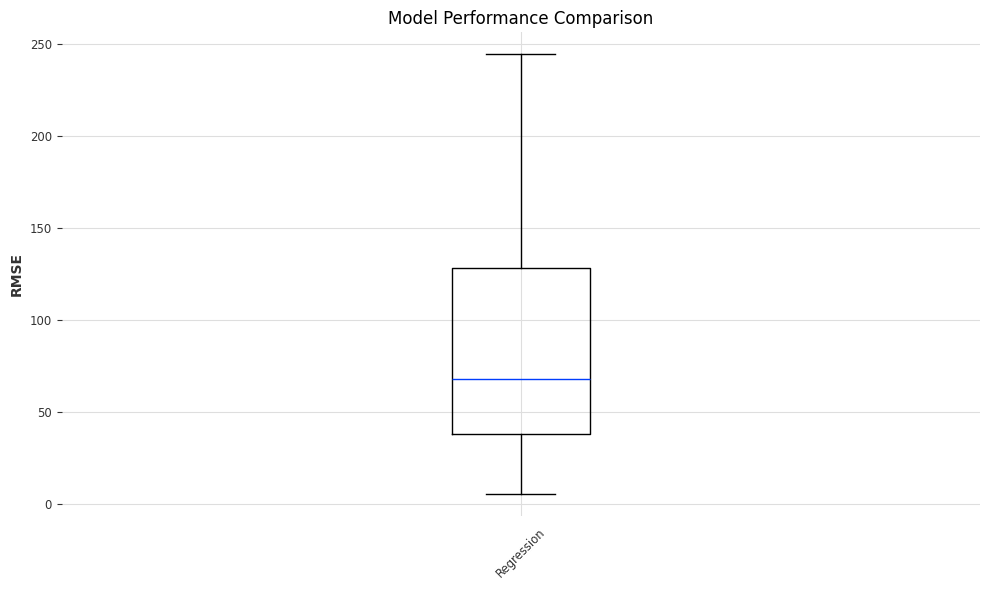

In [21]:
def plot_model_comparison(results, figsize=(10, 6)):
    """Plot boxplots comparing model performances"""
    model_data = []
    model_names = []

    for model_name, queue_results in results.items():
        model_data.append(list(queue_results.values()))
        model_names.extend([model_name] * len(queue_results))

    plt.figure(figsize=figsize)
    plt.boxplot(model_data, tick_labels=results.keys())
    plt.title("Model Performance Comparison")
    plt.ylabel("RMSE")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()


# Add after running analyze_queue_performances
plot_model_comparison(results)

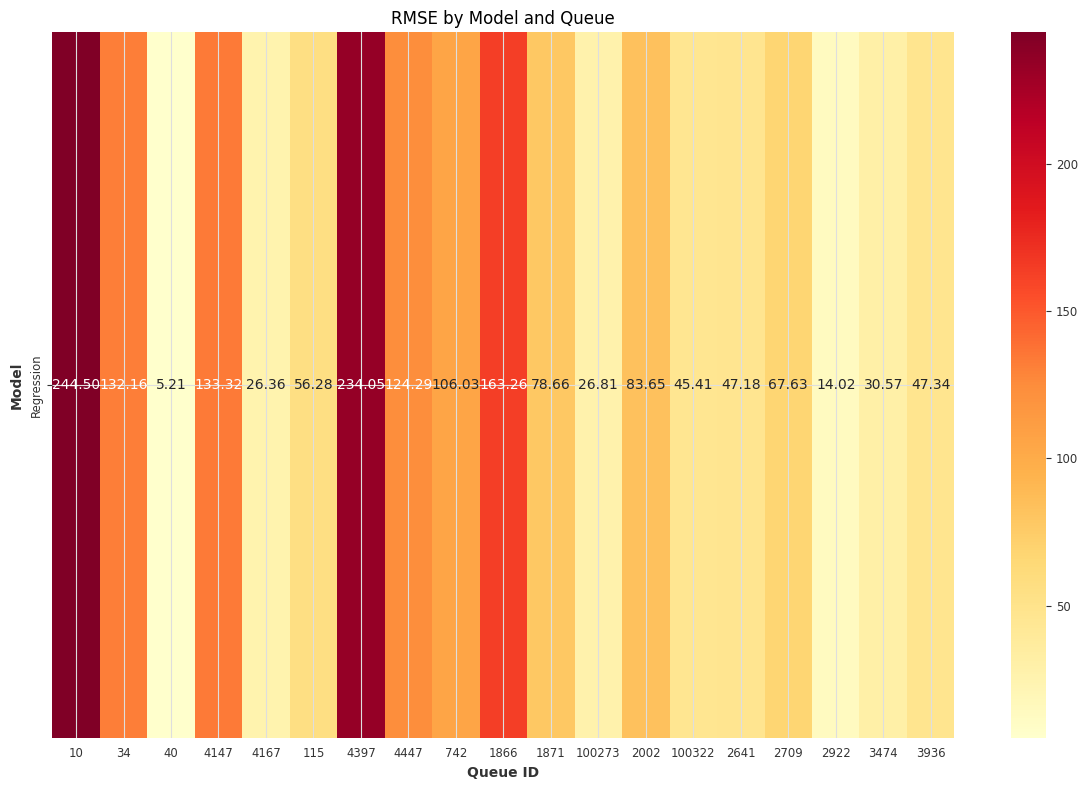

In [22]:
def plot_performance_heatmap(results, figsize=(12, 8)):
    """Plot heatmap of model performances per queue"""
    data = pd.DataFrame(results).T

    plt.figure(figsize=figsize)
    sns.heatmap(data, annot=True, fmt=".2f", cmap="YlOrRd")
    plt.title("RMSE by Model and Queue")
    plt.ylabel("Model")
    plt.xlabel("Queue ID")
    plt.tight_layout()


# Add after running


analyze_queue_performances
plot_performance_heatmap(results)

# Зона старого кода (можно удалять)

In [23]:
start = 0.8
forecast_horizon = 10
backtest = model.historical_forecasts(
    series=ts,
    past_covariates=past_covariates,
    future_covariates=future_covariates,
    start=start,
    retrain=False,
    verbose=True,
    forecast_horizon=forecast_horizon,
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
actual_series = ts.slice_intersect(backtest)
error = rmse(actual_series, backtest)
print(f"Backtest RMSE = {error}")

Backtest RMSE = 248.82812432475404


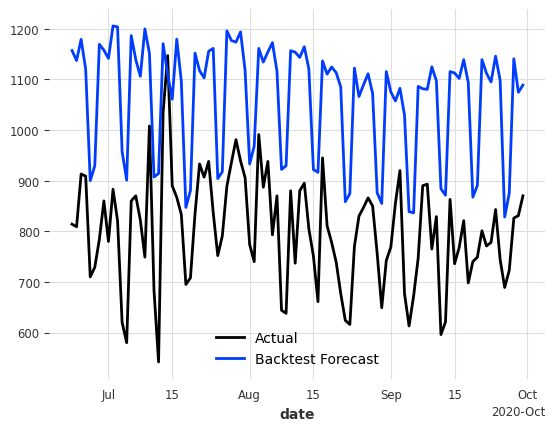

In [25]:
def plot_backtest(ts, backtest, length=100):
    ts[-length:].plot(label="Actual")
    backtest[-length:].plot(label="Backtest Forecast")
    plt.legend()
    plt.show()


plot_backtest(ts, backtest)

In [26]:
def get_queue_data(df, queue_to_all_children, queue_id):
    queues = queue_to_all_children[queue_id]
    df_slice = df[df["queueId"].isin(queues)].groupby("date")[["new_tickets"]].sum()
    return df_slice


def df_to_timeseries(df_slice):
    ts = TimeSeries.from_dataframe(
        df_slice, value_cols="new_tickets", fill_missing_dates=True, freq="D"
    )
    return ts


def generate_past_covariates(df):
    df_total = df.groupby("date")[["new_tickets"]].sum()
    past_covariates = TimeSeries.from_dataframe(
        df_total, value_cols="new_tickets", fill_missing_dates=True, freq="D"
    )
    return past_covariates


def generate_future_covariates(ts, country_code="RU", add_length=None):
    if add_length:
        future_covariates = holidays_timeseries(
            time_index=ts, country_code=country_code, add_length=add_length
        )
    else:
        future_covariates = holidays_timeseries(
            time_index=ts, country_code=country_code
        )
    return future_covariates


def train_model(
    ts,
    past_covariates=None,
    future_covariates=None,
    model_cls=RegressionModel,
    model_kwargs={},
):
    model = model_cls(**model_kwargs)
    model.fit(ts, past_covariates=past_covariates, future_covariates=future_covariates)
    return model


def backtest_model(
    model,
    ts,
    past_covariates=None,
    future_covariates=None,
    start=0.8,
    forecast_horizon=10,
):
    backtest = model.historical_forecasts(
        series=ts,
        past_covariates=past_covariates,
        future_covariates=future_covariates,
        start=start,
        retrain=False,
        verbose=True,
        forecast_horizon=forecast_horizon,
    )
    actual_series = ts.slice_intersect(backtest)
    error = rmse(actual_series, backtest)
    print(f"Backtest RMSE = {error}")
    return backtest, error


def plot_backtest(ts, backtest, length=100):
    ts[-length:].plot(label="Actual")
    backtest[-length:].plot(label="Backtest Forecast")
    plt.legend()
    plt.show()


def eval_model(
    model,
    ts,
    past_covariates=None,
    future_covariates=None,
    start=0.8,
    forecast_horizon=10,
):
    backtest, error = backtest_model(
        model,
        ts,
        past_covariates=past_covariates,
        future_covariates=future_covariates,
        start=start,
        forecast_horizon=forecast_horizon,
    )
    plot_backtest(ts, backtest)
    return backtest, error


def predict_future(model, n_predict, past_covariates=None, future_covariates=None):
    prediction = model.predict(
        n=n_predict,
        past_covariates=past_covariates,
        future_covariates=future_covariates,
    )
    return prediction


def predict_new_tickets(
    df,
    queue_to_all_children,
    queue_id,
    n_predict=10,
    model_cls=RegressionModel,
    model_kwargs={},
    country_code="RU",
):
    df_slice = get_queue_data(df, queue_to_all_children, queue_id)
    ts = df_to_timeseries(df_slice)

    past_covariates = generate_past_covariates(df)
    future_covariates = generate_future_covariates(
        ts,
        country_code=country_code,
        add_length=n_predict,
    )
    model = train_model(
        ts,
        past_covariates=past_covariates,
        future_covariates=future_covariates,
        model_cls=model_cls,
        model_kwargs=model_kwargs,
    )

    prediction = model.predict(
        n=n_predict,
        past_covariates=past_covariates,
        future_covariates=future_covariates,
    )
    return prediction

In [27]:
queue_id = 1871

model_kwargs = {
    "lags": 30,
    "lags_past_covariates": list(range(-29, 0)),
    "lags_future_covariates": [0],
}
df_slice = get_queue_data(df, queue_to_all_children, queue_id)
ts = df_to_timeseries(df_slice)
n_predict = 60
model = LinearRegressionModel(lags=30)
eval_model(model, ts)

NameError: name 'queue_to_all_children' is not defined

In [ ]:
prediction = predict_new_tickets(
    df,
    queue_to_all_children,
    queue_id,
    n_predict=n_predict,
    model_cls=RegressionModel,
    model_kwargs=model_kwargs,
    country_code="RU",
)

prediction.plot(label="Prediction")
plt.legend()
plt.show()

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
ValueError: The `past_covariates` are not long enough. Given horizon `n=60`, `min(lags_past_covariates)=-29`, `max(lags_past_covariates)=-1` and `output_chunk_length=1`, the `past_covariates` have to range from 2020-09-02 00:00:00 until 2020-11-28 00:00:00 (inclusive), but they only range from 2017-01-01 00:00:00 until 2020-09-30 00:00:00.


ValueError: The `past_covariates` are not long enough. Given horizon `n=60`, `min(lags_past_covariates)=-29`, `max(lags_past_covariates)=-1` and `output_chunk_length=1`, the `past_covariates` have to range from 2020-09-02 00:00:00 until 2020-11-28 00:00:00 (inclusive), but they only range from 2017-01-01 00:00:00 until 2020-09-30 00:00:00.

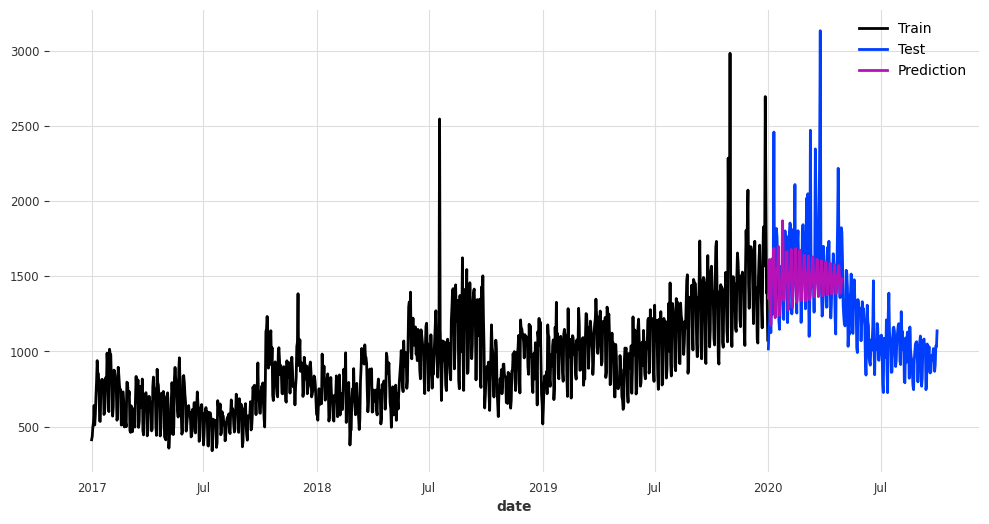

In [ ]:
# queue_id = 1871
# df_slice = get_queue_data(df, queue_to_all_children, queue_id)
# ts = df_to_timeseries(df_slice)

# model, train, test, prediction = train_and_predict(ts, n_predict=120)

# plot_results(train, test, prediction)

# top_10_queue_ids = top_queues
# scores = get_top_queues_scores(df, queue_to_all_children, top_10_queue_ids)

# future_prediction = predict_new_tickets(
#     df, queue_to_all_children, queue_id, n_predict=60
# )

In [ ]:
from darts import TimeSeries
from darts.models import RegressionModel
from darts.metrics import rmse
from darts.utils.timeseries_generation import holidays_timeseries
import matplotlib.pyplot as plt


def get_queue_data(df, queue_to_all_children, queue_id):
    queues = queue_to_all_children[queue_id]
    return df[df["queueId"].isin(queues)].groupby("date")[["new_tickets"]].sum()


def df_to_timeseries(df_slice):
    return TimeSeries.from_dataframe(
        df_slice, value_cols="new_tickets", fill_missing_dates=True, freq="D"
    )


def generate_past_covariates(df):
    df_total = df.groupby("date")[["new_tickets"]].sum()
    return TimeSeries.from_dataframe(
        df_total, value_cols="new_tickets", fill_missing_dates=True, freq="D"
    )


def generate_future_covariates(ts, country_code="RU", add_length=None):
    return holidays_timeseries(
        time_index=ts, country_code=country_code, add_length=add_length
    )


def train_model(ts, model_cls=RegressionModel, model_kwargs={}, **covariates):
    model = model_cls(**model_kwargs)
    model.fit(ts, **covariates)
    return model


def backtest_model(model, ts, start=0.8, forecast_horizon=10, **covariates):
    backtest = model.historical_forecasts(
        series=ts,
        start=start,
        retrain=False,
        verbose=True,
        forecast_horizon=forecast_horizon,
        **covariates,
    )
    error = rmse(ts.slice_intersect(backtest), backtest)
    print(f"Backtest RMSE = {error}")
    return backtest, error


def plot_backtest(ts, backtest, length=100):
    ts[-length:].plot(label="Actual")
    backtest[-length:].plot(label="Backtest Forecast")
    plt.legend()
    plt.show()


def eval_model(
    ts,
    model_cls=RegressionModel,
    model_kwargs={},
    start=0.8,
    forecast_horizon=10,
    **covariates,
):
    model = train_model(
        ts, model_cls=model_cls, model_kwargs=model_kwargs, **covariates
    )
    backtest, error = backtest_model(
        model, ts, start=start, forecast_horizon=forecast_horizon, **covariates
    )
    plot_backtest(ts, backtest)
    return backtest, error


def predict_future(model, n_predict, **covariates):
    return model.predict(n=n_predict, **covariates)


def predict_new_tickets(
    df,
    queue_to_all_children,
    queue_id,
    n_predict=10,
    model_cls=RegressionModel,
    model_kwargs={},
    country_code="RU",
):
    df_slice = get_queue_data(df, queue_to_all_children, queue_id)
    ts = df_to_timeseries(df_slice)
    past_covariates = generate_past_covariates(df)
    future_covariates = generate_future_covariates(
        ts, country_code=country_code, add_length=n_predict
    )

    model = train_model(
        ts,
        model_cls=model_cls,
        model_kwargs=model_kwargs,
        past_covariates=past_covariates,
        future_covariates=future_covariates,
    )
    prediction = predict_future(
        model,
        n_predict,
        past_covariates=past_covariates,
        future_covariates=future_covariates,
    )

    prediction.plot(label="Prediction")
    plt.legend()
    plt.show()
    return prediction


In [ ]:
predict_new_tickets(df, queue_to_all_children, queue_id)

ValueError: At least one of `lags`, `lags_future_covariates` or `lags_past_covariates` must be not None.


ValueError: At least one of `lags`, `lags_future_covariates` or `lags_past_covariates` must be not None.

In [ ]:
# darts.utils.timeseries_generation.holidays_timeseries

In [ ]:
flow_train, _ = flow.split_before(0.8)


def eval_model(model, past_covariates=None, future_covariates=None):
    # Past and future covariates are optional because they won't always be used in our tests

    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(
        series=flow,
        past_covariates=past_covariates,
        future_covariates=future_covariates,
        start=0.8,
        retrain=False,
        verbose=True,
        forecast_horizon=10,
    )

    flow[-len(backtest) - 100 :].plot()
    backtest.plot(label="backtest (n=10)")
    print("Backtest RMSE = {}".format(rmse(flow, backtest)))

In [ ]:
ts.add_holidays("RU")

<TimeSeries (DataArray) (date: 1369, component: 2, sample: 1)> Size: 22kB
array([[[4.120e+02],
        [1.000e+00]],

       [[4.340e+02],
        [1.000e+00]],

       [[4.960e+02],
        [1.000e+00]],

       ...,

       [[1.036e+03],
        [0.000e+00]],

       [[1.031e+03],
        [0.000e+00]],

       [[1.136e+03],
        [0.000e+00]]])
Coordinates:
  * date       (date) datetime64[ns] 11kB 2017-01-01 2017-01-02 ... 2020-09-30
  * component  (component) object 16B 'new_tickets' 'holidays'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
scores

{742: 35.85354820838302,
 1871: 28.822069909364107,
 115: 26.996708884392703,
 4447: 37.44067379019783,
 2641: 41.91344090166164,
 2002: 25.289697722551605,
 10: 23.91855098987389,
 4412: 42.623222805147094,
 34: 30.845904034196394,
 2610: 30.80863606127136}

In [ ]:
df.date.describe()

count                           418327
mean     2019-03-01 08:31:49.778714368
min                2017-01-01 00:00:00
25%                2018-04-20 00:00:00
50%                2019-04-25 00:00:00
75%                2020-02-04 00:00:00
max                2020-09-30 00:00:00
Name: date, dtype: object

<Axes: xlabel='date'>

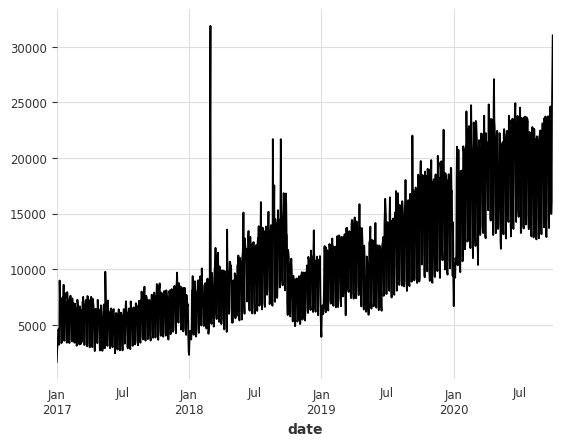

In [ ]:
df.groupby("date").sum("new_tickets")["new_tickets"].plot()

In [ ]:
df.head()

,queueId,date,new_tickets
0,1,2017-01-01,15
1,1,2017-01-02,26
2,1,2017-01-03,25
3,1,2017-01-04,29
4,1,2017-01-05,26


## use all queues and use hierarchy (WIP)

In [ ]:
df_wide = df.pivot(index="date", columns="queueId", values="new_tickets")
df_wide = df_wide.reset_index()

In [ ]:
df_wide.head()

queueId,date,1,7,9,10,13,14,18,25,26,...,101339,101340,101341,101343,101344,101349,101350,101351,101352,101359
0,2017-01-01,15.0,8.0,2.0,16.0,28.0,1.0,13.0,106.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-02,26.0,23.0,NaN,23.0,24.0,2.0,16.0,140.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-03,25.0,23.0,NaN,28.0,22.0,4.0,20.0,140.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-04,29.0,20.0,2.0,25.0,33.0,7.0,12.0,175.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-05,26.0,27.0,NaN,28.0,22.0,5.0,11.0,137.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_wide.shape

(1369, 829)

In [ ]:
df_wide = df_wide.fillna(0)

In [ ]:
series = TimeSeries.from_dataframe(df_wide, "date", fill_missing_dates=True, freq="D")

In [ ]:
len(series)

1369

In [ ]:
n_val = 100
train, val = series[:-n_val], series[-n_val:]

In [ ]:
len(train), len(val)

(1269, 100)

In [ ]:
preds = []
for component in series.components:
    model = LinearRegressionModel(lags=100)
    model.fit(train[component])
    preds.append(model.predict(n=len(val)))

pred = concatenate(preds, axis="component")

In [ ]:
pred

<TimeSeries (DataArray) (date: 100, component: 828, sample: 1)> Size: 662kB
array([[[1.75738442e+02],
        [8.14410583e+01],
        [8.20393274e-03],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[1.63577858e+02],
        [7.99662316e+01],
        [8.09696134e-02],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[1.71662427e+02],
        [8.10634459e+01],
        [9.22956561e-03],
        ...,
...
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[1.21041612e+02],
        [7.85678737e+01],
        [2.41874389e-01],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[1.29281620e+02],
        [7.81881589e+01],
        [2.28996892e-01],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]]])
Coordinates:
  * date       (date) datetime64[ns] 800B 2020-06-23 2020-06-24 ... 2020-09-30
  * component  (component) object 7kB '1' '7' '9' ... '101351' '101352' '101359'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
model = LinearRegressionModel(lags=12)
model.fit(train)
pred = model.predict(n=len(val))

In [ ]:
series.components

Index(['1', '7', '9', '10', '13', '14', '18', '25', '26', '29',
       ...
       '101339', '101340', '101341', '101343', '101344', '101349', '101350',
       '101351', '101352', '101359'],
      dtype='object', name='component', length=828)

<Axes: xlabel='date'>

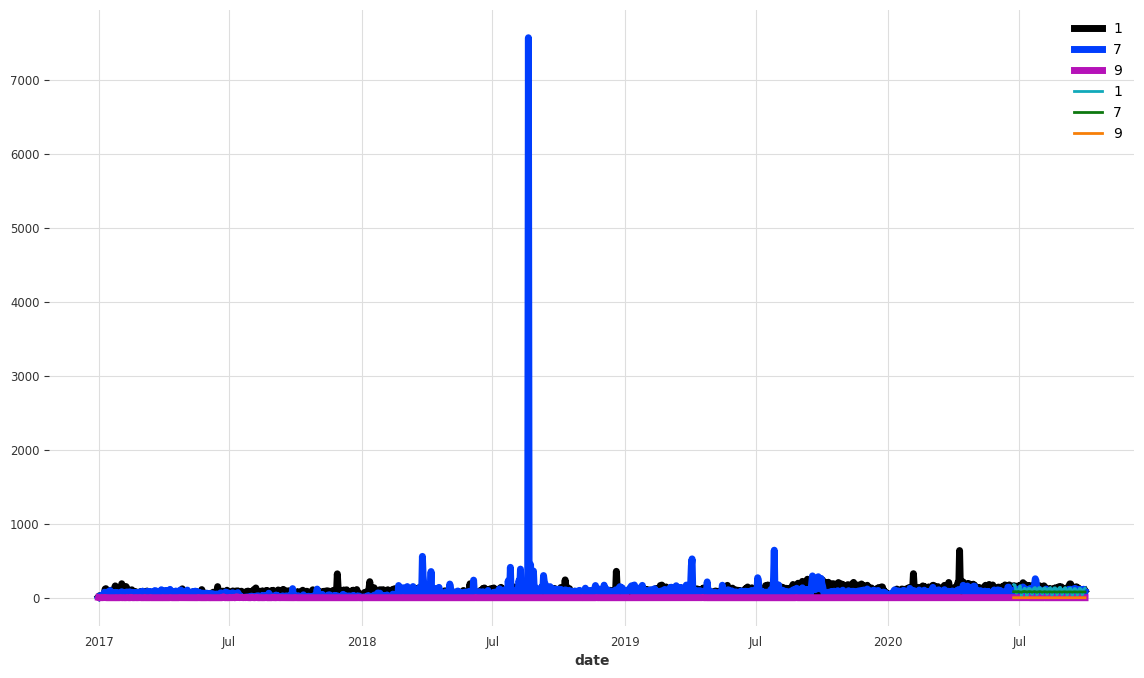

In [ ]:
plt.figure(figsize=(14, 8))
components_to_show = ["1", "7", "9"]
series[components_to_show].plot(lw=5)
pred[components_to_show].plot(lw=2)

In [ ]:
def measure_mae(pred):
    def print_mae_on_subset(subset, name):
        print(
            "mean MAE on {}: {:.2f}".format(
                name,
                mae(pred[subset], val[subset]),
            )
        )

    print_mae_on_subset(["Total"], "total")
    print_mae_on_subset(reasons, "reasons")
    print_mae_on_subset(regions, "regions")
    print_mae_on_subset(regions_reasons_comps, "(region, reason)")
    print_mae_on_subset(regions_reasons_city_comps, "(region, reason, city)")

In [ ]:
measure_mae(pred)